In [1]:
from __future__ import print_function
import numpy as np    
import csv
import copy
import random
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import pandas
from numpy import linspace
from scipy.interpolate import UnivariateSpline
from random import seed
from random import choice

In [2]:
Data_1  = pandas.read_excel('FEFF9_XANES.xlsx', 'Cu1.5Te')
Data_2  = pandas.read_excel('FEFF9_XANES.xlsx', 'Cu2Te')
Data_3  = pandas.read_excel('FEFF9_XANES.xlsx', 'CuTe')

mult = 5

In [3]:
# create known coeff matrix for compute actual Y
coeff_a = 0.32
coeff_b = 0.27
coeff_c = 0.41
coeffs_known = [0.0]*3
coeffs_known[0] = coeff_a
coeffs_known[1] = coeff_b
coeffs_known[2] = coeff_c

In [4]:
cf = np.max(coeffs_known)
cf

0.41

In [5]:
# create energy point with specific evenly spaced samples
xs = linspace(8970, 9050, 1000)

In [6]:
# get the smooth line from the data, so that we can choose any point with a contoguous energy 
s1 = UnivariateSpline(Data_1.omega[:], Data_1.mu[:], s=0)
y1 = s1(xs)
s2 = UnivariateSpline(Data_2.omega[:], Data_2.mu[:], s=0)
y2 = s2(xs)
s3 = UnivariateSpline(Data_3.omega[:], Data_3.mu[:], s=0)
y3 = s3(xs)

In [7]:
# initiate the XX which is input reference spectra cooresponding to the choosen energy 
# YY are the target spectra cooresponding to the choosen energy 
# both of these does not show the energy we choose
XX = [[0.0 for a in range(3)] for b in range(1000)]
YY = [0.0]*1000

In [8]:
# create a target spectrum as our actual spectra value
for i in range(0,1000):
    XX[i][0] = y1[i]
    XX[i][1] = y2[i]
    XX[i][2] = y3[i]

    YY[i] = y1[i]*coeff_a + y2[i]*coeff_b + y3[i]*coeff_c + 0.10

In [9]:
# in this case we have 1000 energy point, and 3 reference spextra
n = 1000
m = 3

In [10]:
import numpy as np


def xanes_derivatives(mu_df, dx=0.80808080808):
    '''
    This function calculates and returns the first and second derivative of a series of XANES spectra.
    Inputs:
        mu_df = Pandas dataframe of averaged XANES spectra absorption values.
        dx = distance between uniformly distributed energy values in XANES spectra. Defaulted to value provided in data.
    '''
    for nums in range(len(mu_df)):
        if nums == 0:
            pass

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)])

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)):
            if j == len(mu_df.columns)-1:
                pass
            else:
                dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)):
            if j_ == len(mu_df.columns)-1:
                pass
            else:
                dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx

    return dmu1, dmu2

In [11]:
import pandas as pd
df_YY = pd.DataFrame(YY).transpose()
df_YY
#this is a mu-energy(index) row

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.129952,0.130216,0.130477,0.130735,0.130992,0.131247,0.131499,0.13175,0.131999,0.132247,...,1.114224,1.114352,1.114474,1.11459,1.114699,1.114802,1.114897,1.114986,1.115069,1.115144


In [12]:
dmu1, dmu2=xanes_derivatives(df_YY)

In [13]:
dmu1.shape

(1, 1000)

In [14]:
dmu2.shape

(1, 1000)

In [15]:
#divide the list into n sublist base on the index, eg from 0-5, 5-10
def partition(lst, n):
    division = len(lst) / n
    return [lst[round(division * i):round(division * (i + 1))] for i in range(n)]

In [16]:
divi_part_list=partition(dmu2[0], 20)

In [17]:
divi_part_list[0]

array([-3.67133932e-06, -3.49761941e-06, -3.32389952e-06, -3.15017962e-06,
       -2.97645971e-06, -2.80273982e-06, -2.62901991e-06, -2.45530002e-06,
       -2.28158013e-06, -2.10786021e-06, -1.93414032e-06, -1.76042043e-06,
       -1.58670051e-06, -1.41298062e-06, -1.23926073e-06, -1.06554081e-06,
       -8.91820919e-07, -7.18101027e-07, -5.44381111e-07, -3.70661227e-07,
       -1.96941311e-07, -2.32214197e-08,  1.50498472e-07,  3.24218388e-07,
        4.97938280e-07,  6.71658171e-07,  8.45378088e-07,  1.01909798e-06,
        1.19281787e-06,  1.36653779e-06,  1.54025768e-06,  1.71397757e-06,
        1.88769749e-06,  2.06141737e-06,  2.23513729e-06,  2.40885718e-06,
        2.58257707e-06,  2.75629699e-06,  2.93001688e-06,  3.10373677e-06,
        3.27745668e-06,  3.45117658e-06,  3.62489647e-06,  3.79861638e-06,
        3.97233627e-06,  4.14605618e-06,  4.31977607e-06,  4.49349596e-06,
        4.66721588e-06,  4.84093577e-06])

In [18]:
# only select 2 smallest second derviate in each region
from heapq import nsmallest
dmu2_list_nsmallest=[]
for i in range(len(divi_part_list)):
    dmu2_list_nsmallest.append(nsmallest(2, divi_part_list[i]))
dmu2_list_nsmallest

[[-3.6713393241478155e-06, -3.4976194059621297e-06],
 [5.014655663885e-06, 5.1883755835584965e-06],
 [1.6826239449346335e-05, 1.7203852223908316e-05],
 [2.7769736685588753e-05, 5.809716472877783e-05],
 [-0.0002247101376577737, -0.0002243438983366899],
 [-0.0001324918979214555, -0.00013232019236180908],
 [-0.00021072902775258763, -0.0002096397016044506],
 [-0.0001474391241886534, -0.0001406410710888323],
 [4.0915627628486204e-06, 5.580972683300757e-06],
 [-1.8881668617920416e-05, -1.681094412257572e-05],
 [-3.844864842831386e-05, -3.7126093929480015e-05],
 [-3.9596268464348074e-05, -3.9293276849234575e-05],
 [-1.8332779150266438e-05, -1.7268833443151382e-05],
 [1.4375312048903802e-05, 1.4406160858979339e-05],
 [4.96713049494281e-06, 5.273983572521652e-06],
 [-1.6827814962461217e-06, -1.6735231732031558e-06],
 [-1.5337162027716412e-06, -1.5239037997228294e-06],
 [1.04428885730118e-06, 1.1782670415966544e-06],
 [-5.011083296665756e-06, -4.895067555355413e-06],
 [-0.0001152872226607257, -1

In [19]:
dmu2_list=dmu2[0].tolist()
smallest_dmu2_index=[]
for element in np.nditer(np.array(dmu2_list_nsmallest)):
    print(element)
    index = dmu2_list.index(element)
    print(index)
    smallest_dmu2_index.append(index)

-3.6713393241478155e-06
0
-3.4976194059621297e-06
1
5.014655663885e-06
50
5.1883755835584965e-06
51
1.6826239449346335e-05
100
1.7203852223908316e-05
101
2.7769736685588753e-05
199
5.809716472877783e-05
198
-0.0002247101376577737
212
-0.0002243438983366899
211
-0.0001324918979214555
282
-0.00013232019236180908
281
-0.00021072902775258763
340
-0.0002096397016044506
339
-0.0001474391241886534
350
-0.0001406410710888323
351
4.0915627628486204e-06
449
5.580972683300757e-06
448
-1.8881668617920416e-05
499
-1.681094412257572e-05
498
-3.844864842831386e-05
549
-3.7126093929480015e-05
548
-3.9596268464348074e-05
571
-3.9293276849234575e-05
570
-1.8332779150266438e-05
600
-1.7268833443151382e-05
601
1.4375312048903802e-05
699
1.4406160858979339e-05
698
4.96713049494281e-06
749
5.273983572521652e-06
748
-1.6827814962461217e-06
784
-1.6735231732031558e-06
785
-1.5337162027716412e-06
800
-1.5239037997228294e-06
801
1.04428885730118e-06
899
1.1782670415966544e-06
898
-5.011083296665756e-06
949
-4.8

In [20]:
smallest_dmu2_index

[0,
 1,
 50,
 51,
 100,
 101,
 199,
 198,
 212,
 211,
 282,
 281,
 340,
 339,
 350,
 351,
 449,
 448,
 499,
 498,
 549,
 548,
 571,
 570,
 600,
 601,
 699,
 698,
 749,
 748,
 784,
 785,
 800,
 801,
 899,
 898,
 949,
 948,
 998,
 997]

In [21]:
# use these smallest second derivate to predict YY
# only use these second derivate energy to train the model and use other data to test
# is not good because the smallest are concentrated, we may need to divide the spectrum to differnet range
# and from each range we select the smallest derviate
selection = np.reshape(smallest_dmu2_index,len(smallest_dmu2_index))
selection


array([  0,   1,  50,  51, 100, 101, 199, 198, 212, 211, 282, 281, 340,
       339, 350, 351, 449, 448, 499, 498, 549, 548, 571, 570, 600, 601,
       699, 698, 749, 748, 784, 785, 800, 801, 899, 898, 949, 948, 998,
       997])

In [22]:
# initiate the X_train matrix
X_train_fl = [[0.0 for a in range(m)] for b in range(len(selection))]
X_train_fl

[[0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0]]

In [23]:
for i in range(0,len(smallest_dmu2_index)):
        for j in range(0,m):
            X_train_fl[i][j] = copy.deepcopy(np.float(XX[selection[i]][j]))

In [24]:
X_train_fl

[[0.02877413156234397, 0.028936078862357138, 0.031540406598236606],
 [0.02902431108639213, 0.029202167177854066, 0.03181256325710529],
 [0.040530263465595615, 0.04108660230158878, 0.04475574482387675],
 [0.04079405998658747, 0.04135225419281765, 0.04506413050617893],
 [0.05940627460009456, 0.05997062504223977, 0.0674359132958494],
 [0.059956006126381946, 0.060519018519959965, 0.06811074169863554],
 [0.33817788375080066, 0.33540907911324774, 0.4432245825439804],
 [0.3292402055020619, 0.32637734985332584, 0.4321109952559863],
 [0.4551396254575152, 0.4536604460646478, 0.5784888002527228],
 [0.44653053923169606, 0.44495277840396175, 0.5690633496890046],
 [0.8543541133516965, 0.8540065447006875, 0.9786736245582203],
 [0.850543796667629, 0.850593776947332, 0.9759138700809137],
 [1.0051529965170123, 1.0074109860758045, 1.0310297712592973],
 [1.0040321670529961, 1.0060202823005686, 1.0322386366738878],
 [1.0097036825123438, 1.0176798798606377, 1.0091046551058114],
 [1.009502444639129, 1.018415

In [25]:
X_train_fl_array=np.array(X_train_fl)
X_train_fl_array

array([[0.02877413, 0.02893608, 0.03154041],
       [0.02902431, 0.02920217, 0.03181256],
       [0.04053026, 0.0410866 , 0.04475574],
       [0.04079406, 0.04135225, 0.04506413],
       [0.05940627, 0.05997063, 0.06743591],
       [0.05995601, 0.06051902, 0.06811074],
       [0.33817788, 0.33540908, 0.44322458],
       [0.32924021, 0.32637735, 0.432111  ],
       [0.45513963, 0.45366045, 0.5784888 ],
       [0.44653054, 0.44495278, 0.56906335],
       [0.85435411, 0.85400654, 0.97867362],
       [0.8505438 , 0.85059378, 0.97591387],
       [1.005153  , 1.00741099, 1.03102977],
       [1.00403217, 1.00602028, 1.03223864],
       [1.00970368, 1.01767988, 1.00910466],
       [1.00950244, 1.01841594, 1.00608414],
       [0.94175485, 0.93467285, 0.92623801],
       [0.94046366, 0.93519803, 0.92462046],
       [0.98549696, 0.9754382 , 0.98908757],
       [0.98513225, 0.97364798, 0.98794531],
       [1.01657779, 1.03898908, 1.00847566],
       [1.01528304, 1.03817262, 1.00925773],
       [1.

In [26]:
len(smallest_dmu2_index)

40

In [27]:
len(X_train_fl_array[0])

3

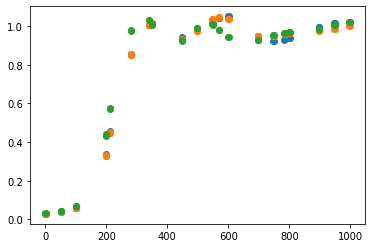

In [28]:
plt.scatter(smallest_dmu2_index, X_train_fl_array[:,0], marker='o')
plt.scatter(smallest_dmu2_index, X_train_fl_array[:,1], marker='o')
plt.scatter(smallest_dmu2_index, X_train_fl_array[:,2], marker='o')

In [29]:
len(selection)

40

In [45]:
coeffs = [[0.0 for a in range(m)] for b in range(len(selection)-10)]
rmse_prop = [0.0]*(len(selection)-10)
Pred_test_ndarray=[0.0]*(len(selection)-10)
for k in range(0,len(selection)-10):
    n_tr = 10+k

    X_train_fl = [[0.0 for a in range(m)] for b in range(n_tr)]
    for i in range(0,n_tr):
        for j in range(0,m):
            X_train_fl[i][j] = copy.deepcopy(np.float(XX[selection[i]][j]))
    Prop_train_fl = np.zeros(n_tr)
    for i in range(0,n_tr):
        Prop_train_fl[i] = copy.deepcopy(float(YY[selection[i]]))

    lassoreg = Lasso(alpha=0.005, normalize=False, max_iter=1e6)
    lassoreg.fit(X_train_fl,Prop_train_fl)
    Pred_train = lassoreg.predict(X_train_fl)

    for z in range(0,m):
        coeffs[k][z] = lassoreg.coef_[z]

    XX_new = [[0.0 for a in range(m)] for b in range(n)]
    for s in range(0,n):
        for t in range(0,m):
            XX_new[s][t] = copy.deepcopy(np.float(XX[s][t]))
    Pred_test = lassoreg.predict(XX_new)

    Pred_test_fl = np.zeros(n)
    for i in range(0,n):
        Pred_test_fl[i] = np.float(Pred_test[i])

    mse_prop = sklearn.metrics.mean_squared_error(YY,Pred_test_fl)
    rmse_prop[k] = np.sqrt(mse_prop)
    Pred_test_ndarray[k]= Pred_test_fl

In [31]:
coeffs

[[0.0, 0.0, 0.7653347865808666],
 [0.0, 0.0, 0.8466691470943654],
 [0.0, 0.0, 0.8700018750275201],
 [0.0, 0.24907119175043452, 0.6806874981146804],
 [0.0, 0.382514626829634, 0.5696272733314716],
 [0.0, 0.46477160012553914, 0.4977713169858042],
 [0.0, 0.5040782968170433, 0.462554887502935],
 [0.0, 0.5279244876778665, 0.4404541972563785],
 [0.11948999725157748, 0.42813275986350846, 0.4217574625751452],
 [0.5545209226720044, 0.008765336408113653, 0.40685781350661243],
 [0.5692877729580349, 0.0002157028326798797, 0.4003580702964881],
 [0.2839252908651439, 0.29400012049390695, 0.39226187762450737],
 [0.13314809696163987, 0.44752630497181195, 0.3887361180738374],
 [0.14473315712947862, 0.4502136421764802, 0.3739520217387319],
 [0.14686480916297456, 0.4582548474346882, 0.3630348817968139],
 [0.22756131458489273, 0.3912811555879275, 0.34857666599591003],
 [0.26977298477132355, 0.3569664358524119, 0.3396808209203534],
 [0.2582191407924075, 0.37159829784102355, 0.3356006742030293],
 [0.248632189

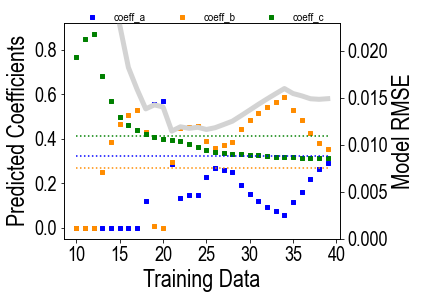

In [60]:
plt.rc('font', family='Arial narrow')

fig, ax1 = plt.subplots(1,1)
plt.subplots_adjust(left=0.16, bottom=0.17, right=0.80, top=0.92)


l = len(coeffs)
xx = [0.0]*l
yy1 = [0.0]*l
yy2 = [0.0]*l
yy3 = [0.0]*l

for i in range(0,l):
    xx[i] = i+10
    yy1[i] = coeffs[i][0]
    yy2[i] = coeffs[i][1]
    yy3[i] = coeffs[i][2]





#plt.text(min_train+20, 6, 'n = ', fontsize=16)
#plt.text(min_train+80, 6, min_train, fontsize=16)


ax1.scatter(xx, yy1, c='blue', marker='s', s=10, alpha=1.0, label='coeff_a')
ax1.scatter(xx, yy2, c='darkorange', marker='s', s=10, alpha=1.0, label='coeff_b')
ax1.scatter(xx, yy3, c='green', marker='s', s=10, alpha=1.0, label='coeff_c')


aa = [0.0]*l
bb = [0.0]*l
cc = [0.0]*l

for i in range(0,l):
    aa[i] = coeff_a
    bb[i] = coeff_b
    cc[i] = coeff_c


ax1.plot(xx, aa, c='blue', ls=':')
ax1.plot(xx, bb, c='darkorange', ls=':')
ax1.plot(xx, cc, c='green', ls=':')

#plt.plot(xx, rmse_prop, c='m', ls=':')



ax1.set_ylabel('Predicted Coefficients', color='k', fontname='Arial Narrow', size=24)
ax1.set_xlabel('Training Data', color='k', fontname='Arial Narrow', size=24)
ax1.set_ylim([min(np.min(yy1), np.min(yy2), np.min(yy3))-0.05, max(np.max(yy1), np.max(yy2), np.max(yy3))+0.05 ])






ax2 = ax1.twinx()
ax2.plot(xx, rmse_prop, c='lightgrey', ls='-', lw=5)
ax2.set_ylabel('Model RMSE', color='k', fontname='Arial Narrow', size=24)
ax2.set_ylim([0.00,0.023])
#ax2.arrow(40, 0.15, 80, 0.15, head_width=0.05, head_length=0.05, fc='k', ec='k')


plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
#plt.xlim([-10,n_tr+10])
plt.xticks([10, 15, 20, 25, 30, 35, 40])


#plt.legend(loc='lower center',ncol=3, frameon=True, prop={'family':'Arial narrow','size':16})
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False, prop={'family':'Arial narrow','size':12})
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=6, frameon=True, prop={'family':'Arial narrow','size':12})
#plt.plot(b, a, c='k', ls='--')
#plt.plot(b, c, c='k', ls='--')
#plt.savefig('plot.eps', dpi=450)
##plt.show()










In [40]:
Pred_test_fl

array([0.16301215, 0.163264  , 0.16351353, 0.16376082, 0.164006  ,
       0.16424917, 0.16449044, 0.16472991, 0.16496769, 0.1652039 ,
       0.16543864, 0.16567201, 0.16590412, 0.16613508, 0.16636501,
       0.166594  , 0.16682216, 0.1670496 , 0.16727644, 0.16750276,
       0.1677287 , 0.16795434, 0.16817981, 0.1684052 , 0.16863062,
       0.16885619, 0.169082  , 0.16930818, 0.16953481, 0.16976202,
       0.16998991, 0.17021859, 0.17044816, 0.17067874, 0.17091042,
       0.17114332, 0.17137755, 0.17161321, 0.17185041, 0.17208926,
       0.17232986, 0.17257233, 0.17281676, 0.17306328, 0.17331198,
       0.17356297, 0.17381637, 0.17407227, 0.17433079, 0.17459204,
       0.17485611, 0.17512312, 0.17539318, 0.1756664 , 0.17594287,
       0.17622272, 0.17650604, 0.17679294, 0.17708354, 0.17737794,
       0.17767624, 0.17797856, 0.178285  , 0.17859567, 0.17891068,
       0.17923013, 0.17955414, 0.1798828 , 0.18021623, 0.18055454,
       0.18089783, 0.18124621, 0.18159979, 0.18195867, 0.18232

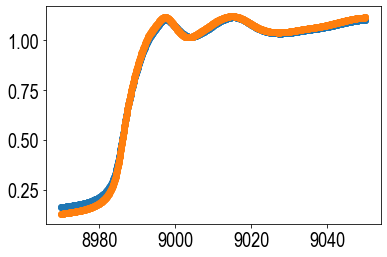

In [33]:
plt.scatter(xs, Pred_test_fl, marker='o')
plt.scatter(xs, YY, marker='o')

In [42]:
selection[25:30]

array([601, 699, 698, 749, 748])

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


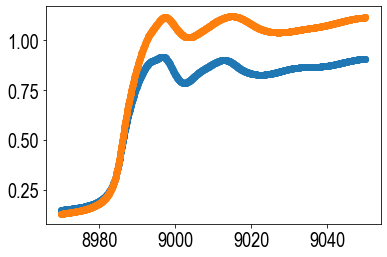

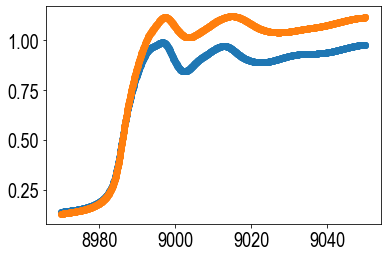

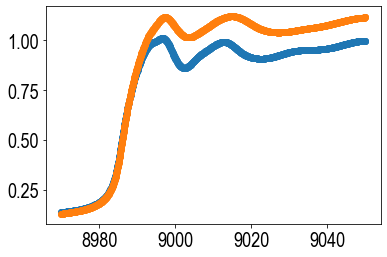

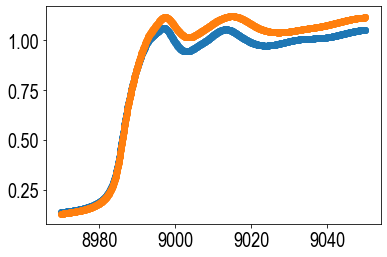

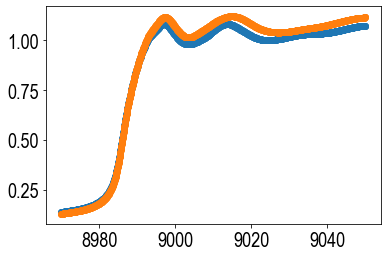

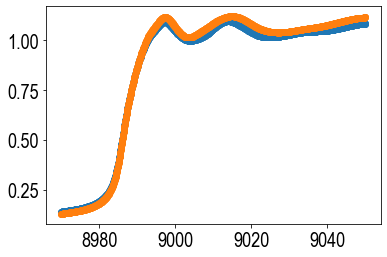

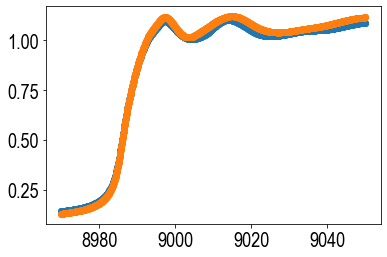

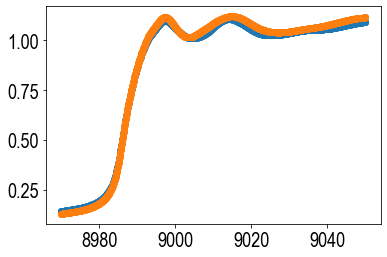

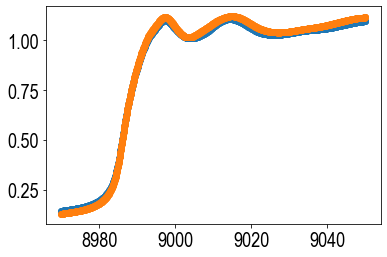

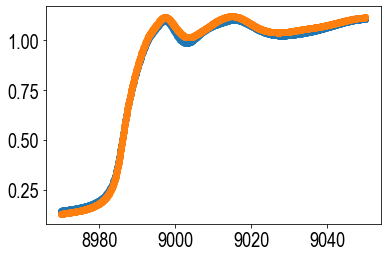

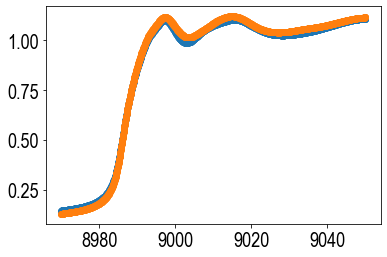

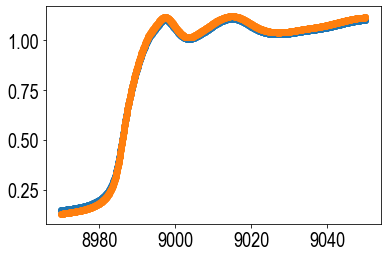

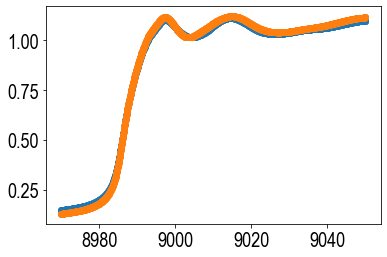

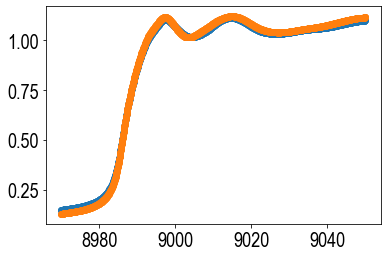

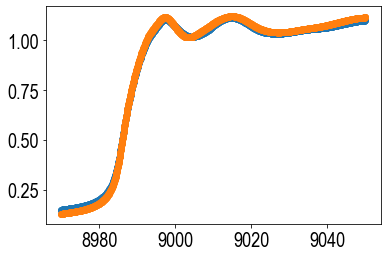

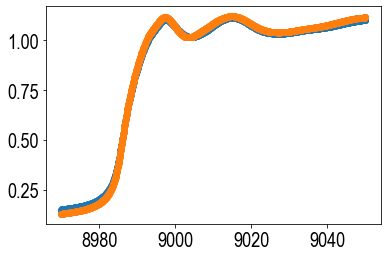

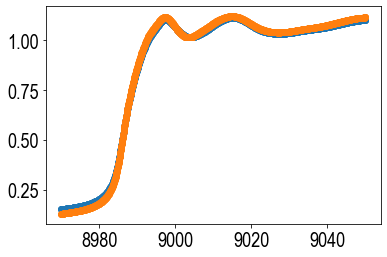

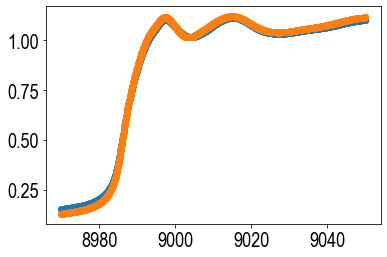

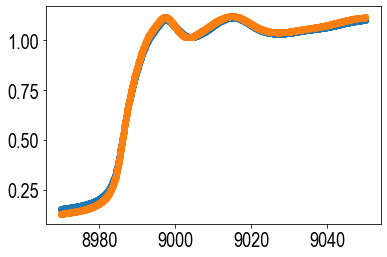

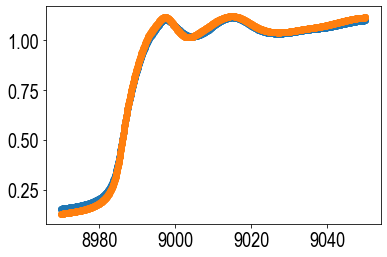

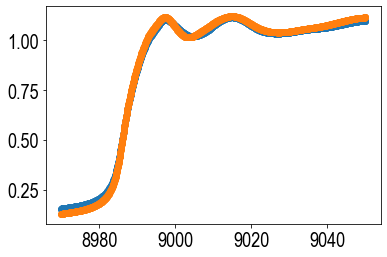

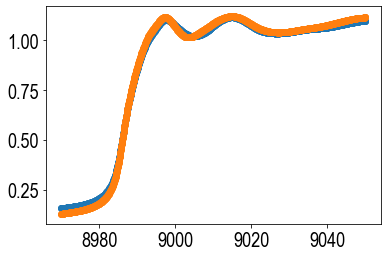

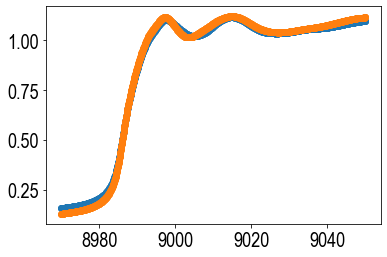

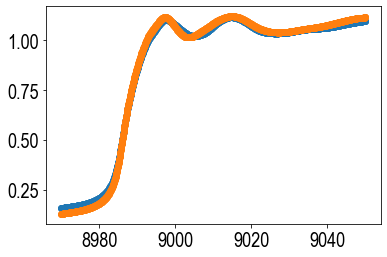

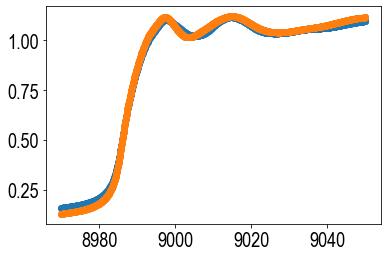

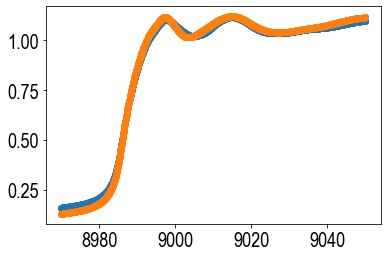

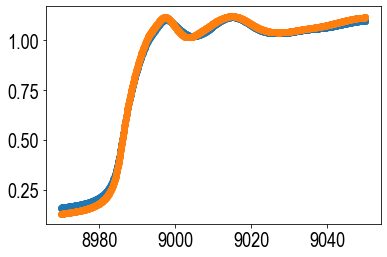

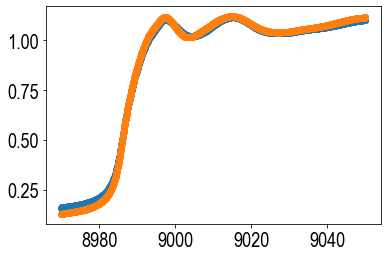

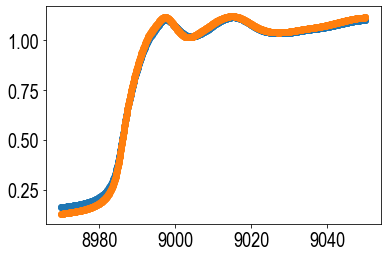

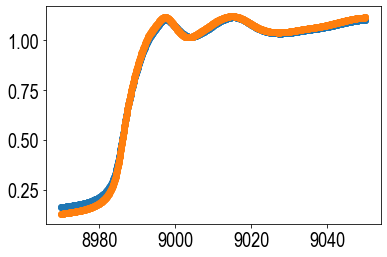

In [53]:
for k in range(len(Pred_test_ndarray)):
    fig, ax = plt.subplots()
    ax.scatter(xs, Pred_test_ndarray[k], marker='o')
    ax.scatter(xs, YY, marker='o')

(0.0, 0.023)

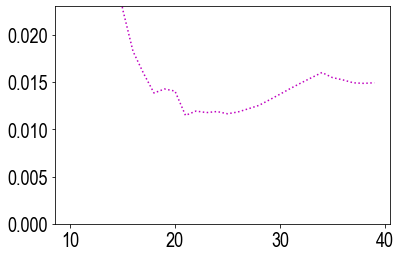

In [57]:
fig, ax = plt.subplots()
ax.plot(xx, rmse_prop, c='m', ls=':')
ax.set_ylim([0.00,0.023])

In [70]:
# form plot may 29-35 cause the noise? so now I remove these data from oue selection 
selection[29:35]
selection2= np.concatenate([selection[:29],selection[35:]])
# initiate the X_train matrix
X_train_fl = [[0.0 for a in range(m)] for b in range(len(selection2))]
X_train_fl

In [72]:
for i in range(0,len(selection2)):
        for j in range(0,m):
            X_train_fl[i][j] = copy.deepcopy(np.float(XX[selection[i]][j]))
X_train_fl_array=np.array(X_train_fl)
X_train_fl_array

array([[0.02877413, 0.02893608, 0.03154041],
       [0.02902431, 0.02920217, 0.03181256],
       [0.04053026, 0.0410866 , 0.04475574],
       [0.04079406, 0.04135225, 0.04506413],
       [0.05940627, 0.05997063, 0.06743591],
       [0.05995601, 0.06051902, 0.06811074],
       [0.33817788, 0.33540908, 0.44322458],
       [0.32924021, 0.32637735, 0.432111  ],
       [0.45513963, 0.45366045, 0.5784888 ],
       [0.44653054, 0.44495278, 0.56906335],
       [0.85435411, 0.85400654, 0.97867362],
       [0.8505438 , 0.85059378, 0.97591387],
       [1.005153  , 1.00741099, 1.03102977],
       [1.00403217, 1.00602028, 1.03223864],
       [1.00970368, 1.01767988, 1.00910466],
       [1.00950244, 1.01841594, 1.00608414],
       [0.94175485, 0.93467285, 0.92623801],
       [0.94046366, 0.93519803, 0.92462046],
       [0.98549696, 0.9754382 , 0.98908757],
       [0.98513225, 0.97364798, 0.98794531],
       [1.01657779, 1.03898908, 1.00847566],
       [1.01528304, 1.03817262, 1.00925773],
       [1.

In [73]:
coeffs = [[0.0 for a in range(m)] for b in range(len(selection2)-10)]
rmse_prop = [0.0]*(len(selection2)-10)
Pred_test_ndarray=[0.0]*(len(selection2)-10)
for k in range(0,len(selection2)-10):
    n_tr = 10+k

    X_train_fl = [[0.0 for a in range(m)] for b in range(n_tr)]
    for i in range(0,n_tr):
        for j in range(0,m):
            X_train_fl[i][j] = copy.deepcopy(np.float(XX[selection[i]][j]))
    Prop_train_fl = np.zeros(n_tr)
    for i in range(0,n_tr):
        Prop_train_fl[i] = copy.deepcopy(float(YY[selection[i]]))

    lassoreg = Lasso(alpha=0.005, normalize=False, max_iter=1e6)
    lassoreg.fit(X_train_fl,Prop_train_fl)
    Pred_train = lassoreg.predict(X_train_fl)

    for z in range(0,m):
        coeffs[k][z] = lassoreg.coef_[z]

    XX_new = [[0.0 for a in range(m)] for b in range(n)]
    for s in range(0,n):
        for t in range(0,m):
            XX_new[s][t] = copy.deepcopy(np.float(XX[s][t]))
    Pred_test = lassoreg.predict(XX_new)

    Pred_test_fl = np.zeros(n)
    for i in range(0,n):
        Pred_test_fl[i] = np.float(Pred_test[i])

    mse_prop = sklearn.metrics.mean_squared_error(YY,Pred_test_fl)
    rmse_prop[k] = np.sqrt(mse_prop)
    Pred_test_ndarray[k]= Pred_test_fl

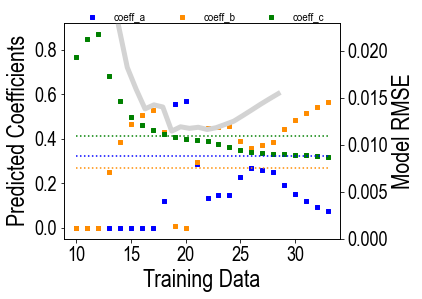

In [74]:
plt.rc('font', family='Arial narrow')

fig, ax1 = plt.subplots(1,1)
plt.subplots_adjust(left=0.16, bottom=0.17, right=0.80, top=0.92)


l = len(coeffs)
xx = [0.0]*l
yy1 = [0.0]*l
yy2 = [0.0]*l
yy3 = [0.0]*l

for i in range(0,l):
    xx[i] = i+10
    yy1[i] = coeffs[i][0]
    yy2[i] = coeffs[i][1]
    yy3[i] = coeffs[i][2]





#plt.text(min_train+20, 6, 'n = ', fontsize=16)
#plt.text(min_train+80, 6, min_train, fontsize=16)


ax1.scatter(xx, yy1, c='blue', marker='s', s=10, alpha=1.0, label='coeff_a')
ax1.scatter(xx, yy2, c='darkorange', marker='s', s=10, alpha=1.0, label='coeff_b')
ax1.scatter(xx, yy3, c='green', marker='s', s=10, alpha=1.0, label='coeff_c')


aa = [0.0]*l
bb = [0.0]*l
cc = [0.0]*l

for i in range(0,l):
    aa[i] = coeff_a
    bb[i] = coeff_b
    cc[i] = coeff_c


ax1.plot(xx, aa, c='blue', ls=':')
ax1.plot(xx, bb, c='darkorange', ls=':')
ax1.plot(xx, cc, c='green', ls=':')

#plt.plot(xx, rmse_prop, c='m', ls=':')



ax1.set_ylabel('Predicted Coefficients', color='k', fontname='Arial Narrow', size=24)
ax1.set_xlabel('Training Data', color='k', fontname='Arial Narrow', size=24)
ax1.set_ylim([min(np.min(yy1), np.min(yy2), np.min(yy3))-0.05, max(np.max(yy1), np.max(yy2), np.max(yy3))+0.05 ])






ax2 = ax1.twinx()
ax2.plot(xx, rmse_prop, c='lightgrey', ls='-', lw=5)
ax2.set_ylabel('Model RMSE', color='k', fontname='Arial Narrow', size=24)
ax2.set_ylim([0.00,0.023])
#ax2.arrow(40, 0.15, 80, 0.15, head_width=0.05, head_length=0.05, fc='k', ec='k')


plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
#plt.xlim([-10,n_tr+10])
plt.xticks([10, 15, 20, 25, 30, 35, 40])


#plt.legend(loc='lower center',ncol=3, frameon=True, prop={'family':'Arial narrow','size':16})
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False, prop={'family':'Arial narrow','size':12})
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=6, frameon=True, prop={'family':'Arial narrow','size':12})
#plt.plot(b, a, c='k', ls='--')
#plt.plot(b, c, c='k', ls='--')
#plt.savefig('plot.eps', dpi=450)
##plt.show()










/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


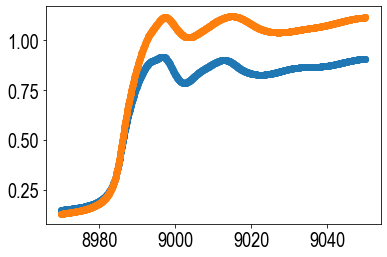

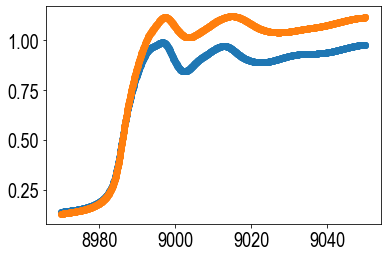

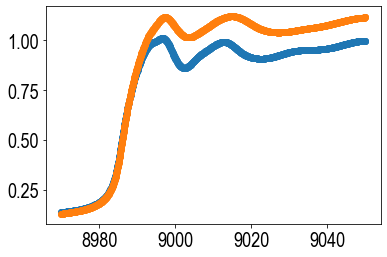

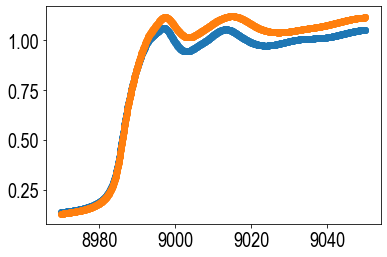

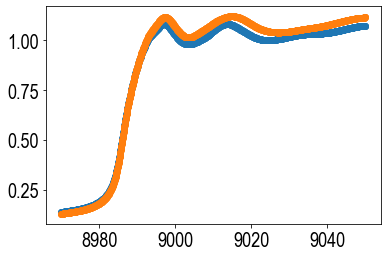

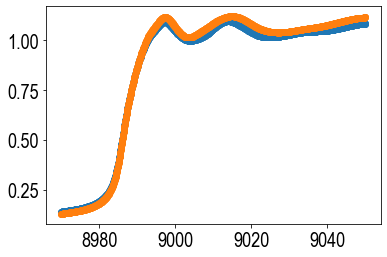

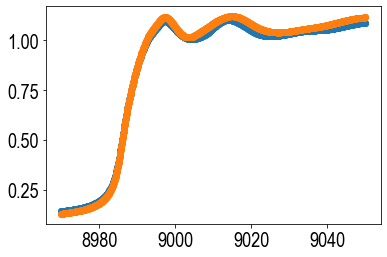

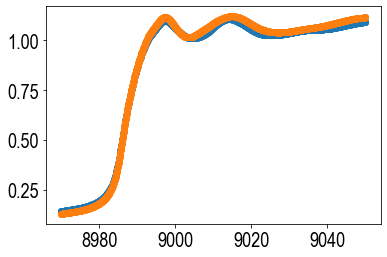

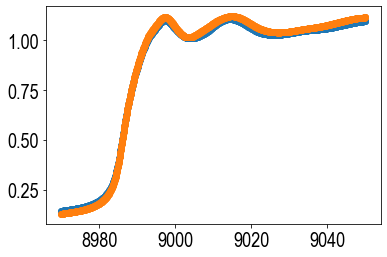

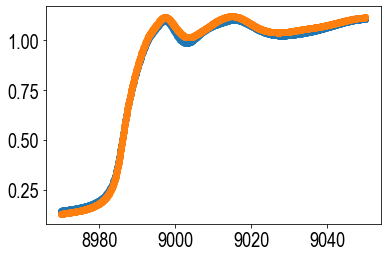

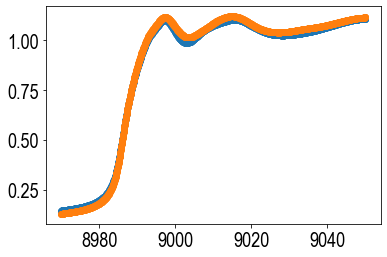

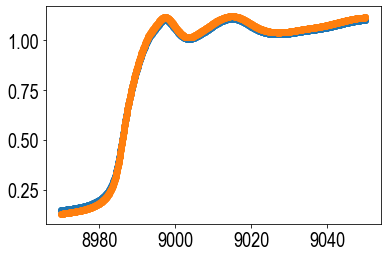

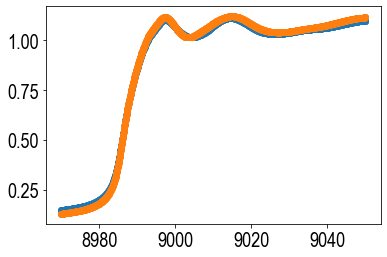

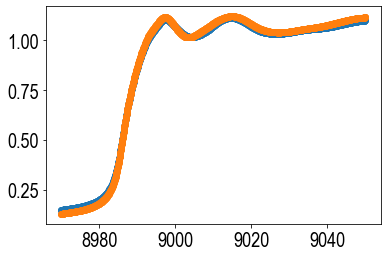

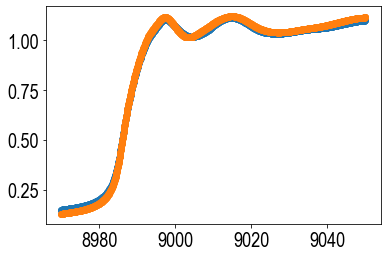

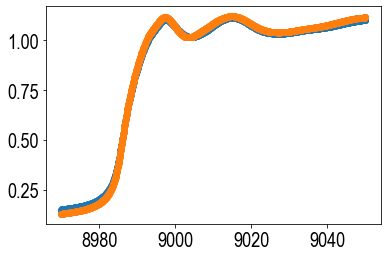

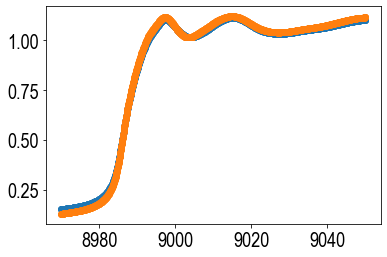

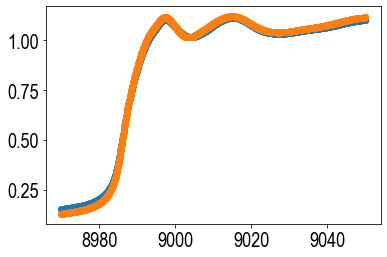

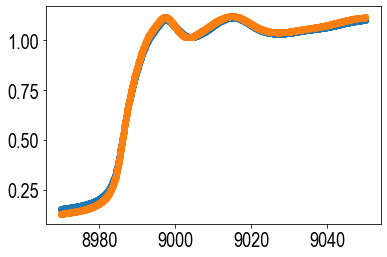

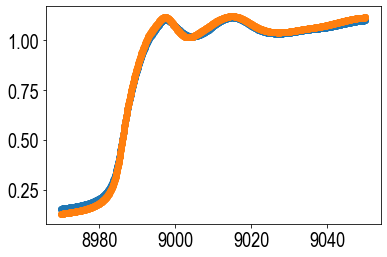

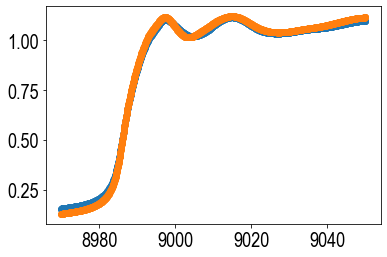

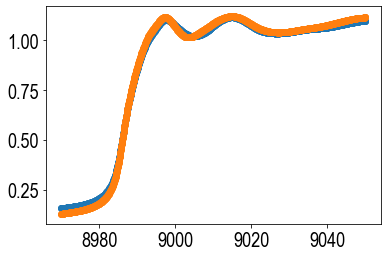

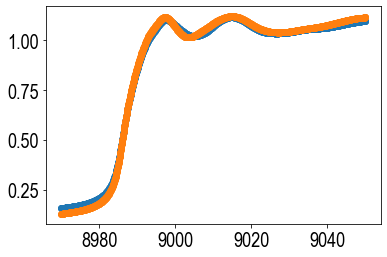

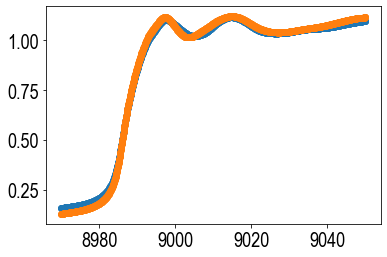

In [75]:
for k in range(len(Pred_test_ndarray)):
    fig, ax = plt.subplots()
    ax.scatter(xs, Pred_test_ndarray[k], marker='o')
    ax.scatter(xs, YY, marker='o')

In [89]:
def choose_select_get_coeff_full_spectrum(selection,m,XX,YY):
    X_train_fl = [[0.0 for a in range(m)] for b in range(len(selection))]
    for i in range(0,len(selection)):
        for j in range(0,m):
            X_train_fl[i][j] = copy.deepcopy(np.float(XX[selection[i]][j]))
    X_train_fl_array=np.array(X_train_fl)
    X_train_fl_array
    coeffs = [[0.0 for a in range(m)] for b in range(len(selection)-10)]
    rmse_prop = [0.0]*(len(selection)-10)
    Pred_test_ndarray=[0.0]*(len(selection)-10)
    for k in range(0,len(selection)-10):
        n_tr = 10+k

        X_train_fl = [[0.0 for a in range(m)] for b in range(n_tr)]
        for i in range(0,n_tr):
            for j in range(0,m):
                X_train_fl[i][j] = copy.deepcopy(np.float(XX[selection[i]][j]))
        Prop_train_fl = np.zeros(n_tr)
        for i in range(0,n_tr):
            Prop_train_fl[i] = copy.deepcopy(float(YY[selection[i]]))

        lassoreg = Lasso(alpha=0.005, normalize=False, max_iter=1e6)
        lassoreg.fit(X_train_fl,Prop_train_fl)
        Pred_train = lassoreg.predict(X_train_fl)

        for z in range(0,m):
            coeffs[k][z] = lassoreg.coef_[z]

        XX_new = [[0.0 for a in range(m)] for b in range(n)]
        for s in range(0,n):
            for t in range(0,m):
                XX_new[s][t] = copy.deepcopy(np.float(XX[s][t]))
        Pred_test = lassoreg.predict(XX_new)

        Pred_test_fl = np.zeros(n)
        for i in range(0,n):
            Pred_test_fl[i] = np.float(Pred_test[i])

        mse_prop = sklearn.metrics.mean_squared_error(YY,Pred_test_fl)
        rmse_prop[k] = np.sqrt(mse_prop)
        Pred_test_ndarray[k]= Pred_test_fl
        plt.rc('font', family='Arial narrow')

    fig, ax1 = plt.subplots(1,1)
    plt.subplots_adjust(left=0.16, bottom=0.17, right=0.80, top=0.92)


    l = len(coeffs)
    xx = [0.0]*l
    yy1 = [0.0]*l
    yy2 = [0.0]*l
    yy3 = [0.0]*l

    for i in range(0,l):
        xx[i] = i+10
        yy1[i] = coeffs[i][0]
        yy2[i] = coeffs[i][1]
        yy3[i] = coeffs[i][2]





    #plt.text(min_train+20, 6, 'n = ', fontsize=16)
    #plt.text(min_train+80, 6, min_train, fontsize=16)


    ax1.scatter(xx, yy1, c='blue', marker='s', s=10, alpha=1.0, label='coeff_a')
    ax1.scatter(xx, yy2, c='darkorange', marker='s', s=10, alpha=1.0, label='coeff_b')
    ax1.scatter(xx, yy3, c='green', marker='s', s=10, alpha=1.0, label='coeff_c')


    aa = [0.0]*l
    bb = [0.0]*l
    cc = [0.0]*l

    for i in range(0,l):
        aa[i] = coeff_a
        bb[i] = coeff_b
        cc[i] = coeff_c


    ax1.plot(xx, aa, c='blue', ls=':')
    ax1.plot(xx, bb, c='darkorange', ls=':')
    ax1.plot(xx, cc, c='green', ls=':')

    #plt.plot(xx, rmse_prop, c='m', ls=':')



    ax1.set_ylabel('Predicted Coefficients', color='k', fontname='Arial Narrow', size=24)
    ax1.set_xlabel('Training Data', color='k', fontname='Arial Narrow', size=24)
    ax1.set_ylim([min(np.min(yy1), np.min(yy2), np.min(yy3))-0.05, max(np.max(yy1), np.max(yy2), np.max(yy3))+0.05 ])






    ax2 = ax1.twinx()
    ax2.plot(xx, rmse_prop, c='lightgrey', ls='-', lw=5)
    ax2.set_ylabel('Model RMSE', color='k', fontname='Arial Narrow', size=24)
    ax2.set_ylim([0.00,0.023])
    #ax2.arrow(40, 0.15, 80, 0.15, head_width=0.05, head_length=0.05, fc='k', ec='k')


    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    #plt.xlim([-10,n_tr+10])
    plt.xticks([10, 15, 20, 25, 30, 35, 40])


    #plt.legend(loc='lower center',ncol=3, frameon=True, prop={'family':'Arial narrow','size':16})
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False, prop={'family':'Arial narrow','size':12})
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=6, frameon=True, prop={'family':'Arial narrow','size':12})
    #plt.plot(b, a, c='k', ls='--')
    #plt.plot(b, c, c='k', ls='--')
    #plt.savefig('plot.eps', dpi=450)
    ##plt.show()

    for k in range(len(Pred_test_ndarray)):
        fig, ax = plt.subplots()
        ax.scatter(xs, Pred_test_ndarray[k], marker='o')
        ax.scatter(xs, YY, marker='o')








/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


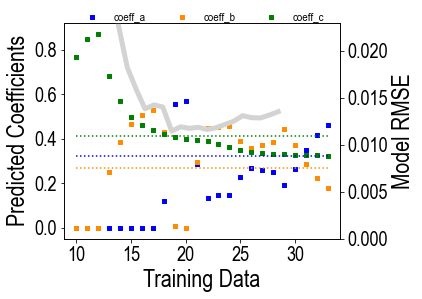

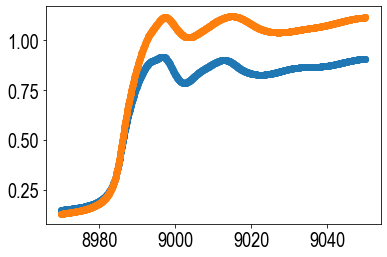

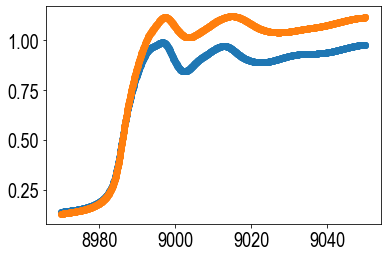

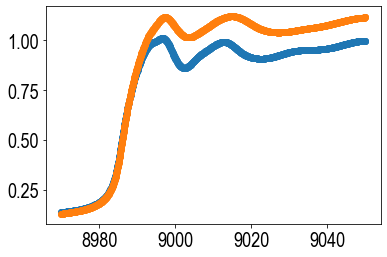

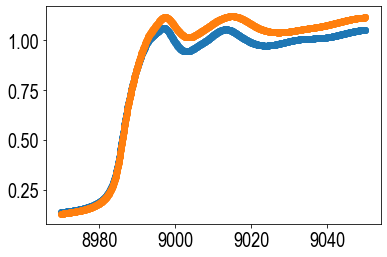

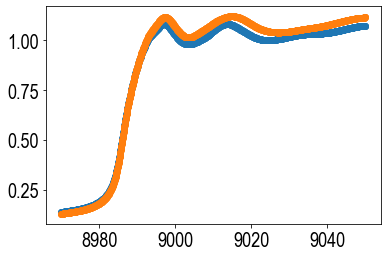

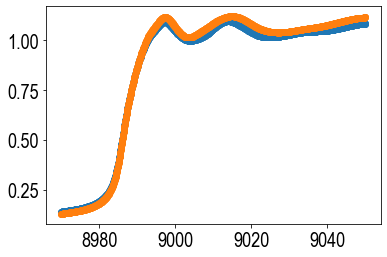

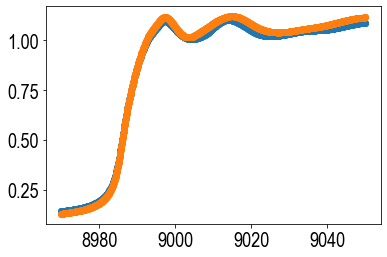

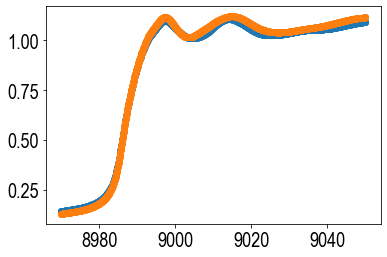

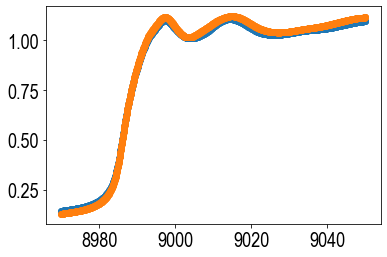

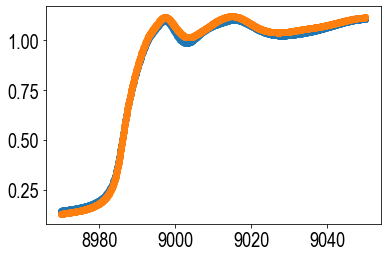

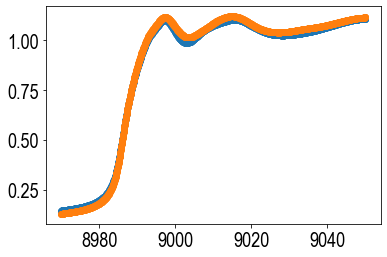

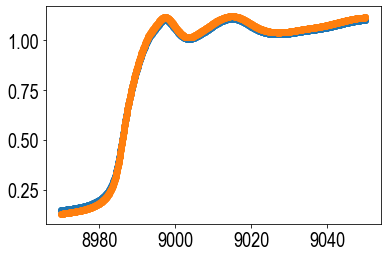

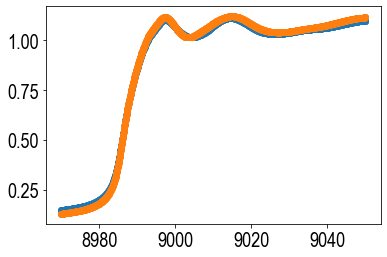

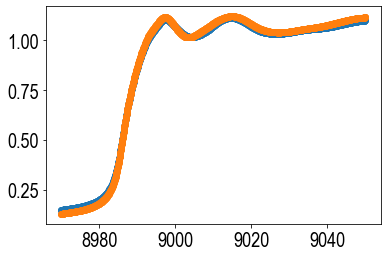

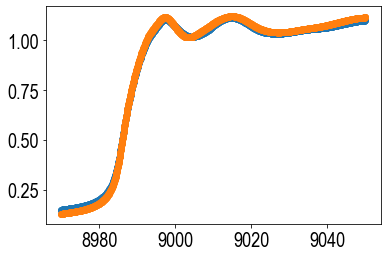

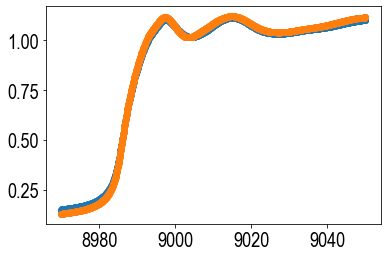

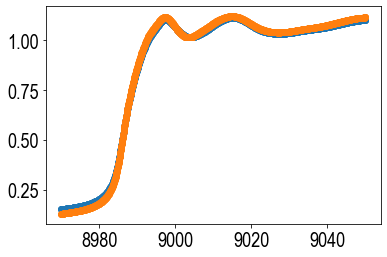

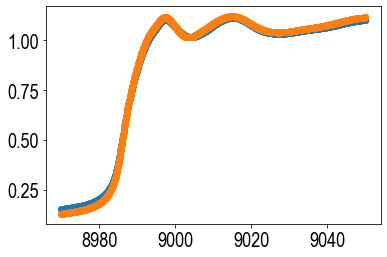

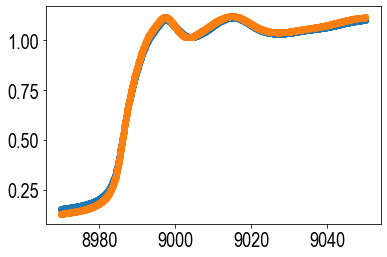

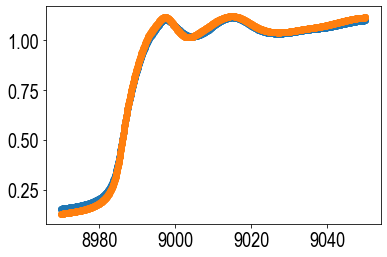

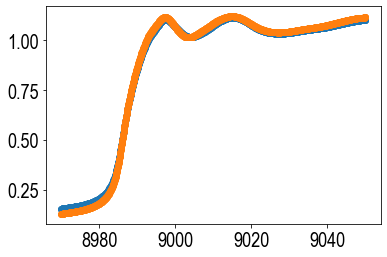

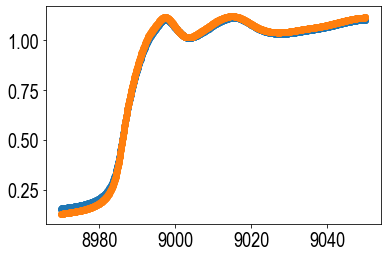

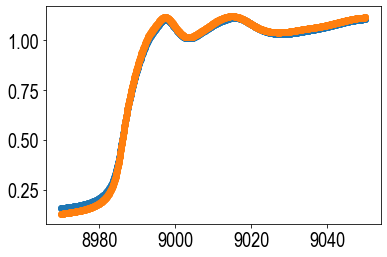

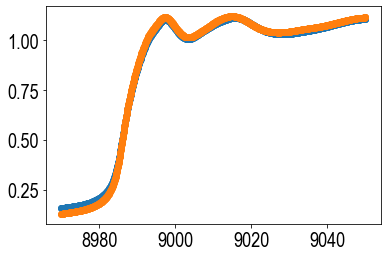

In [90]:
choose_select_get_coeff_full_spectrum(selection2, m,XX,YY)

In [95]:
selection3 = selection2[0:28]

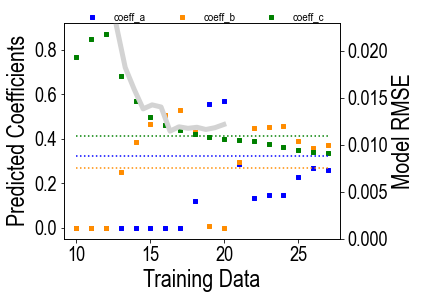

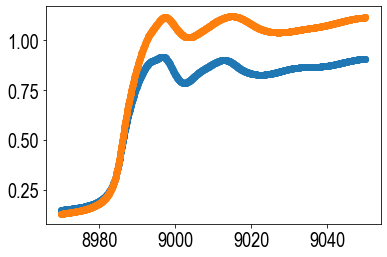

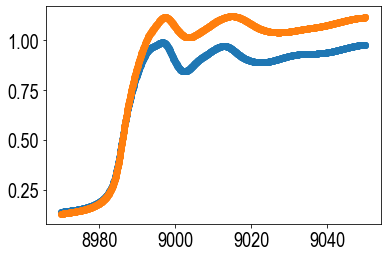

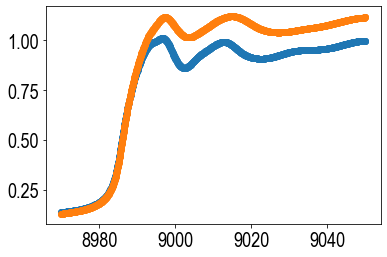

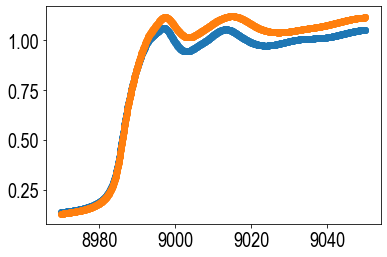

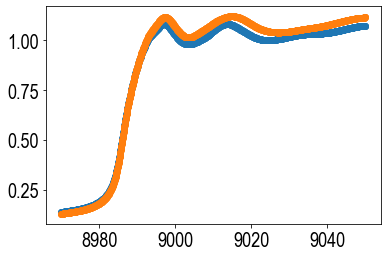

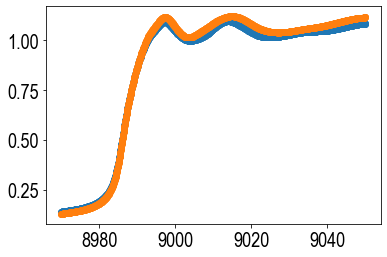

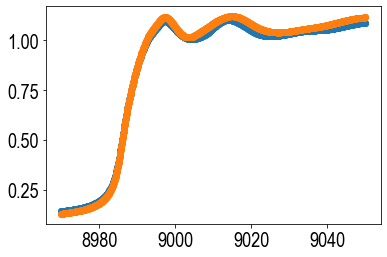

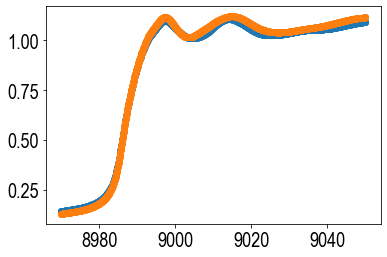

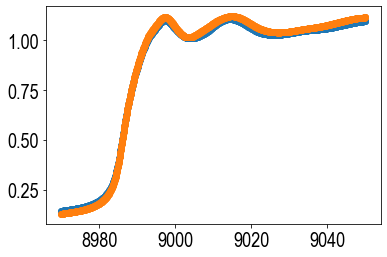

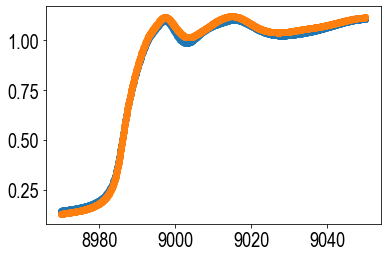

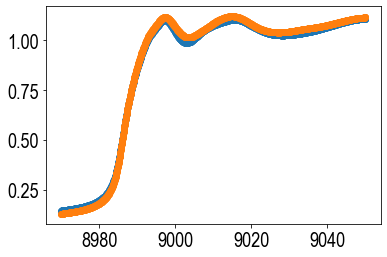

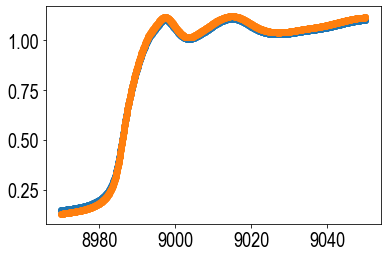

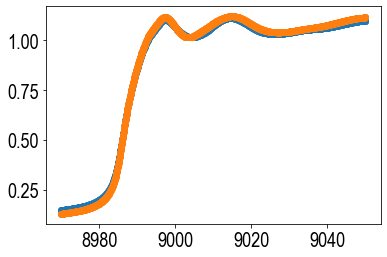

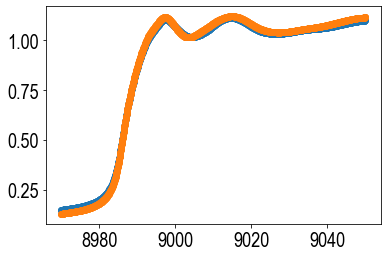

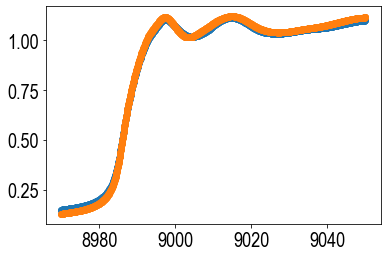

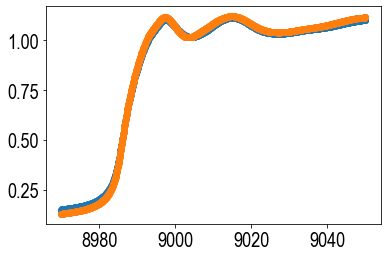

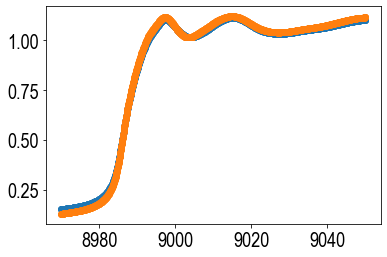

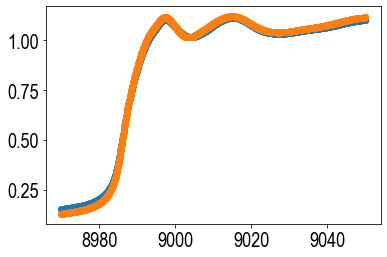

In [96]:
choose_select_get_coeff_full_spectrum(selection3, m,XX,YY)